In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
# Get dataset paths
ds_path = Path('..', '..', '..', '..', 'dataset_extra_data')

train_path = Path(ds_path, 'train')
test_path = Path(ds_path, 'test')
validation_path = Path(ds_path, 'validation')

print(train_path, test_path, validation_path)

..\..\..\dataset_extra_data\train ..\..\..\dataset_extra_data\test ..\..\..\dataset_extra_data\validation


In [3]:
# Specify batch size and image size
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
# Create train dataset from directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Create validation dataset from directory
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Create test dataset from directory
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

NotFoundError: Could not find directory ..\..\..\dataset_extra_data\train

In [7]:
# Get all vegetables (classes)
class_names = train_dataset.class_names
print(class_names)

['Bean', 'Broccoli', 'Carrot', 'Cauliflower', 'Tomato']


In [8]:
# Use buffered prefetching to load the images from disk without I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
# Create a data augmentation layer to use in our new 'transfer-learned' model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
  ]
)

In [10]:
# Create a rescaling layer to preprocess input, since MobileNetV2 expects pixel values between [-1, 1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
# Freeze the convolutional base of MobileNetV2 model
base_model.trainable = False

In [14]:
# Create layer to convert features to to a single 1280-element vector per image
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
# Create layer to convert these features into a single prediction
prediction_layer = layers.Dense(128, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 128)


In [16]:
# Create model with custom layers
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# Check initial model accuracy without training
epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

37/37 [==============================] - 8s 164ms/step - loss: 5.0200 - accuracy: 0.0060


In [19]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10
185/185 [==============================] - 45s 234ms/step - loss: 2.7669 - accuracy: 0.4100 - val_loss: 1.4390 - val_accuracy: 0.7623
Epoch 2/10
185/185 [==============================] - 39s 212ms/step - loss: 0.7824 - accuracy: 0.8666 - val_loss: 0.4813 - val_accuracy: 0.9569
Epoch 3/10
185/185 [==============================] - 40s 213ms/step - loss: 0.3524 - accuracy: 0.9483 - val_loss: 0.2458 - val_accuracy: 0.9828
Epoch 4/10
185/185 [==============================] - 39s 212ms/step - loss: 0.2198 - accuracy: 0.9630 - val_loss: 0.1571 - val_accuracy: 0.9854
Epoch 5/10
185/185 [==============================] - 40s 214ms/step - loss: 0.1636 - accuracy: 0.9709 - val_loss: 0.1139 - val_accuracy: 0.9871
Epoch 6/10
185/185 [==============================] - 40s 213ms/step - loss: 0.1291 - accuracy: 0.9741 - val_loss: 0.0891 - val_accuracy: 0.9888
Epoch 7/10
185/185 [==============================] - 40s 213ms/step - loss: 0.1063 - accuracy: 0.9785 - val_loss: 0.0741 - val_ac

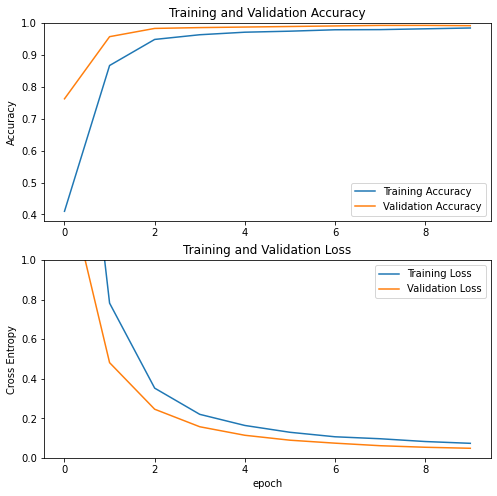

In [20]:
def visualize_stats():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

visualize_stats()

In [21]:
model.save('model_mobilenetV2_epoch10.h5')

In [1]:
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = keras.models.load_model(path_to_model)
print("Done!")

NameError: name 'K' is not defined